# Stackjack

In [1]:
# Some useful libraries
import numpy as np
import matplotlib.pyplot as plt

## Task 1

The reinforcement task is implemented as a python class called `StackJack` in the file `stackjackClass.py`, we only need to import it here.
For convenience, we also import the constants `ACTION_STAND`, `ACTION_STACK_1`, and  `ACTION_STACK_2`, used to encode each action.

In [2]:
from stackjackClass import StackJack, ACTION_STAND, ACTION_STACK_1, ACTION_STACK_2

Using the `.step()` method we can perform some test actions.

In [3]:
sj = StackJack(verbose=True)
print(sj.step(ACTION_STACK_1))
print(sj.step(ACTION_STACK_2))
print(sj.step(ACTION_STAND))

Player card: 3
(-1, 3)
Player card: 15
(-1, 18)
Dealer card: 25
(-10, 27)


Using the `.play()` method we can play interactively (*note: not required for this task*).

In [4]:
sj = StackJack()
# sj.play() # Uncomment to play

## Task 2

Policy evaluation is implemented as a function in `stackjackHelpers.py` which we import here.

In [5]:
from stackjackHelpers import evaluatePolicy

Next, we define the policies.
To use non-deterministic policies, we represent a policy of a list of lists, representing the probabilities of each action in each state, i.e.
```
somePolicy[state] = [P_STAND, P_STACK_1, P_STACK_2]
```

We use the attributes of the `StackJack` class to access constants like the "bust" value or the set of states, but do not call any methods (or even create an instance of it).
These constants could also be stored in regular global variables.

In [6]:
policyStand = [[1, 0, 0] for s in StackJack.STATES]
policyStack1 = [[0, 1, 0] for s in StackJack.STATES]
policyRandom = [[0.3, 0.5, 0.2] for s in StackJack.STATES]

In [7]:
valuesStand = evaluatePolicy(policyStand)
valuesStack1 = evaluatePolicy(policyStack1)
valuesRandom = evaluatePolicy(policyRandom)

Below is a plot illustrating the value functions.

In [8]:
PLOT_IND1 = StackJack.BUST
x = StackJack.STATES[:PLOT_IND1]

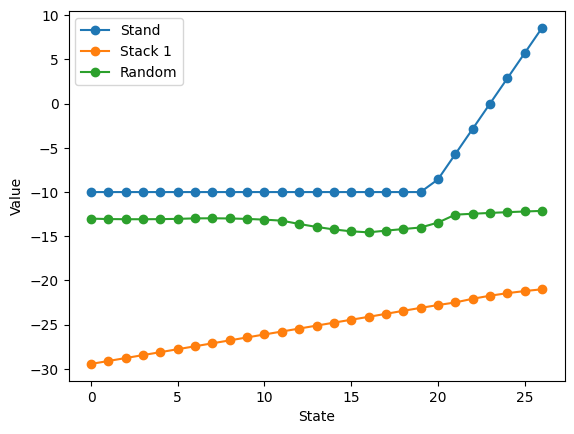

In [9]:
plt.figure()
plt.plot(x, valuesStand[:PLOT_IND1], 'o-', label='Stand')
plt.plot(x, valuesStack1[:PLOT_IND1], 'o-', label='Stack 1')
plt.plot(x, valuesRandom[:PLOT_IND1], 'o-', label='Random')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend()
plt.show()

Some observations:

* "Stand" starts flat at -10, because we are guaranteed to lose with less than 20 points, then increases starting at state 20
* "Stack 1" is at most -21 (immediately going bust) in state 26, and lower before, because we keep paying to draw cards
* "Random" is somewhere between the two

## Task 3

Below we implement policy iteration to find an optimal policy.
First, we import the helper functions `chooseGreedyPolicy` and `evaluatePolicy`, which are used in policy iteration,
and `randomToDeterministicPolicy`, which helps in plotting a deterministic policy.

In [10]:
from stackjackHelpers import chooseGreedyPolicy, evaluatePolicy, randomToDeterministicPolicy

In [11]:
optimalPolicy = [[1, 0, 0] for s in StackJack.STATES]

while True:
    valuesOptimal = evaluatePolicy(optimalPolicy)
    newPolicy = chooseGreedyPolicy(valuesOptimal)
    
    if optimalPolicy == newPolicy:
        break
    
    optimalPolicy = newPolicy

Below is an illustration of the optimal policy.

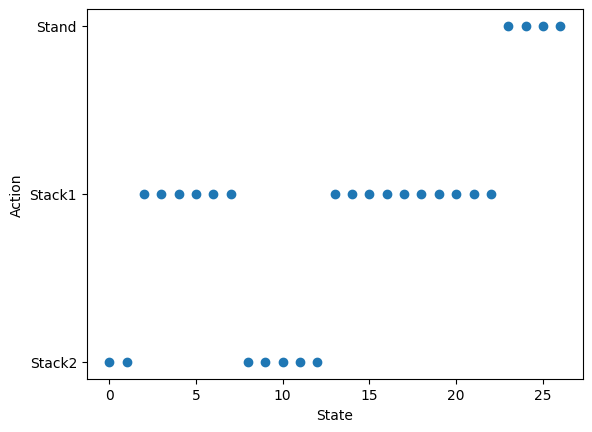

In [12]:
detPolicy = randomToDeterministicPolicy(optimalPolicy)
actionNames = ['Stand', 'Stack1', 'Stack2']
stringPolicy = [actionNames[a] for a in detPolicy]

plt.figure()
plt.scatter(x, stringPolicy[:PLOT_IND1])
plt.xlabel('State')
plt.ylabel('Action')
plt.show()


Combining the value and policy plot might be interesting.

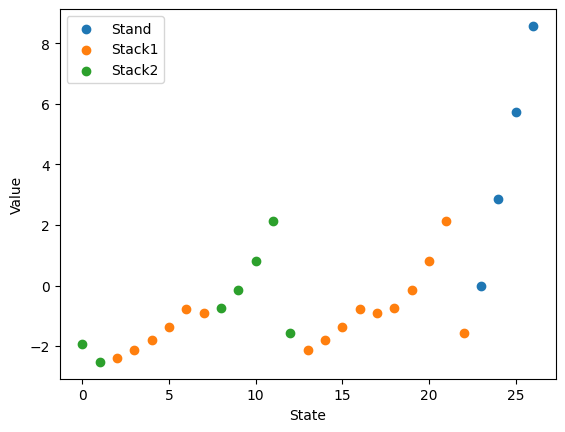

In [13]:
allActions = [ACTION_STAND, ACTION_STACK_1, ACTION_STACK_2]

plt.figure()

for action, actionName in zip(allActions, actionNames):
    x = [s for s in range(StackJack.BUST) if detPolicy[s] == action]
    y = [valuesOptimal[s] for s in x]
    plt.scatter(x, y, label=actionName)
plt.legend()
plt.xlabel('State')
plt.ylabel('Value')
plt.show()

# # Also works, but with a different color palette:
# scatter = plt.scatter(x, valuesOptimal[:PLOT_IND1], c=detPolicy[:PLOT_IND1], cmap='viridis')
# plt.legend(handles = scatter.legend_elements()[0], labels=actionNames)

Lastly, we compute and plot the action-value function for the optimal policy

In [14]:
from stackjackHelpers import evaluateAction

actionValueFunction = []
for state in StackJack.STATES:
    actionValues = [evaluateAction(state, action, valuesOptimal) for action in allActions]
    actionValueFunction.append(actionValues)


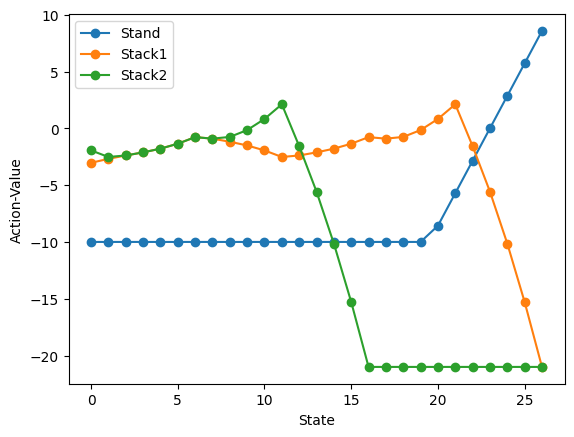

In [15]:
plt.plot(actionValueFunction[:PLOT_IND1], 'o-')
plt.legend(labels = actionNames)
plt.xlabel('State')
plt.ylabel('Action-Value')
plt.show()

Some observations:

* The point-wise maximum of the action-value function is the (state-)value function
* The "Stand" part of the action-value function under the optimal policy is identical to the value function of the "Stand" policy
  * This is not true for "Stack 1"
* The action-value functions of "Stack 2" is identical to that of "Stack 1" when shifted by 10

In [16]:
# Quick computation showing the "shift" claim above:
s1 = [vals[1] for vals in actionValueFunction]
s2 = [vals[2] for vals in actionValueFunction]
d = [v1 - v2 for v1, v2 in zip(s1[10:-1], s2[:-11])]
max(d)

0.0

## Task 4

In this task, we perform a Monte-Carlo (MC) simulation to estimate the value of the initial state under the four policies mentioned above.

First, we define two functions to play a single game under a given policy and another function to play many games.

In [17]:
# Play a single game under a given policy and return the total accumulated rewards
def playOneGame(sj: StackJack, policy, state0=0):
    sj.reset(state0)
    totalRewards = 0
    while sj.state != sj.BUST:
        # Sample an action according to the policy and current state
        actionProbabilities = policy[sj.state]
        action = np.random.choice(allActions, p = actionProbabilities)

        # Take the action and record the reward
        reward, state = sj.step(action)
        totalRewards += reward
        
    return totalRewards

In [18]:
# Perform a MC analysis, by playing many games in a row and recording the rewards
def runMC(policy, N=10000, state0=0):
    sj = StackJack()
    rewards = []
    for i in range(N):
        rewards.append(playOneGame(sj, policy, state0))
    return rewards


Next, we call the functions defined above for each policy.

In [19]:
print('Running MC Stand...')
mcRewardsStand = runMC(policyStand)

print('Running MC Stack1...')
mcRewardsStack1 = runMC(policyStack1)

print('Running MC Random...')
mcRewardsRandom = runMC(policyRandom)

print('Running MC Optimal...')
mcRewardsOptimal = runMC(optimalPolicy)

Running MC Stand...
Running MC Stack1...
Running MC Random...
Running MC Optimal...


Below, we illustrate the results of each MC simulation in a histogram and compute the estimated values to the ones computed above using dynamic programming (DP).

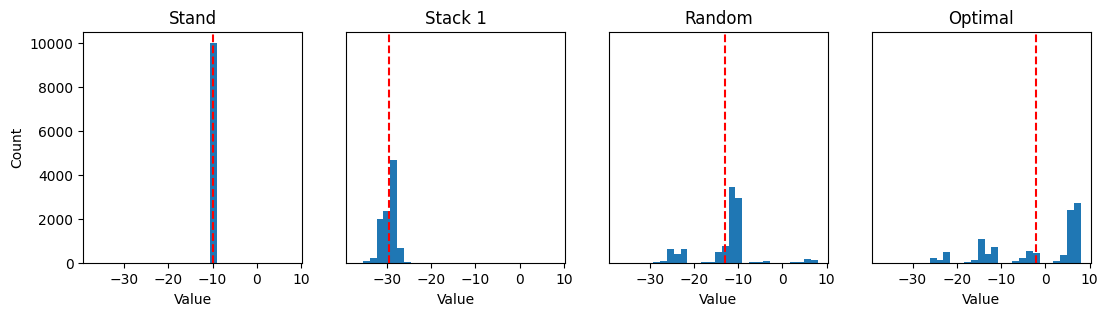

In [20]:
# Create a (wide) figure to show all histograms
fig = plt.figure(figsize=(13, 3))

# Compute (shared) bins
allVals = mcRewardsStand + mcRewardsStack1 + mcRewardsRandom + mcRewardsOptimal
bins = np.linspace(min(allVals), max(allVals), num=30)

# Plot histograms
ax1 = plt.subplot(1, 4, 1)
plt.hist(mcRewardsStand, bins=bins)
plt.axvline(x = np.mean(mcRewardsStand), color='red', linestyle='--', )
plt.title('Stand')
plt.ylabel('Count')
plt.xlabel('Value')

plt.subplot(1, 4, 2, sharex=ax1, sharey=ax1)
plt.hist(mcRewardsStack1, bins=bins)
plt.axvline(x = np.mean(mcRewardsStack1), color='red', linestyle='--', )
plt.tick_params(left=False, labelleft=False)
plt.title('Stack 1')
plt.xlabel('Value')

plt.subplot(1, 4, 3, sharex=ax1, sharey=ax1)
plt.hist(mcRewardsRandom, bins=bins)
plt.axvline(x = np.mean(mcRewardsRandom), color='red', linestyle='--', )
plt.tick_params(left=False, labelleft=False)
plt.title('Random')
plt.xlabel('Value')

plt.subplot(1, 4, 4, sharex=ax1, sharey=ax1)
plt.hist(mcRewardsOptimal, bins=bins)
plt.axvline(x = np.mean(mcRewardsOptimal), color='red', linestyle='--', )
plt.tick_params(left=False, labelleft=False)
plt.title('Optimal')
plt.xlabel('Value')

plt.show()

In [21]:
mcRewards = [mcRewardsStand, mcRewardsStack1, mcRewardsRandom, mcRewardsOptimal]
dpValues = [valuesStand, valuesStack1, valuesRandom, valuesOptimal]
labels = ['Stand', 'Stack1', 'Random', 'Optimal']

for mcData, values, label in zip(mcRewards, dpValues, labels):
    print('"' + label + '"')
    print('MC-estimate:', np.mean(mcData))
    print('DP-value:   ', values[0])
    print('Difference: ', np.mean(mcData) - values[0])
    print('MC-std.-dev:', np.std(mcData))
    print('')

"Stand"
MC-estimate: -10.0
DP-value:    -10.0
Difference:  0.0
MC-std.-dev: 0.0

"Stack1"
MC-estimate: -29.4579
DP-value:    -29.444428201234338
Difference:  -0.013471798765660736
MC-std.-dev: 1.4537632510144147

"Random"
MC-estimate: -13.0526
DP-value:    -13.007765454490036
Difference:  -0.04483454550996413
MC-std.-dev: 6.273454649553147

"Optimal"
MC-estimate: -2.0367
DP-value:    -1.9443828443428575
Difference:  -0.09231715565714271
MC-std.-dev: 10.655616036156708



Some observations:

* The MC results are fairly close to the computed values
* For "Stand" there is no error, since the game outcome is deterministic in this scenario
* The larger error of the MC estimate for "Optimal" is in line with the higher standard devation (also visible in the histogram)
* This analysis could be expanded to verify the results for other states as well